В исходном файле находятся данные по результатам парсинга поисковой выдачи маркетплейса
по более чем 100 различным поисковым запросам, в разных регионах, за один день. 

# 1. Обработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df= pd.read_parquet('search_data.parquet')
df.head()

,Дата парсинга,Выдача,Номенклатура,Рейтинг,Отзывы,Цена,Стоимость рекламы,Позиция с рекламой,Позиция до рекламы,Регион,Новинка,Модель,Запрос,Акция,Бренд,Название,Реклама,Остатки,Тип рекламы
0,2025-09-12,1,172706235,4.9,223,316,2151,1,444,Казань,None,iPhone 11 Pro,apple iphone 11 pro чехол,СКИДКИ ПОСПЕЛИ,MagicCase,Силиконовый чехол на iPhone 11 Pro с защитой к...,Да,Электросталь WB:53;,поиск
1,2025-09-12,1,481174536,0.0,0,350,0,0,0,Казань,None,iPhone 11 Pro,apple iphone 11 pro чехол pinterest,СКИДКИ ПОСПЕЛИ,CHEHOO,Чехол на iPhone 11 Pro с драконом,None,СЦ Кавказский бульвар:29;,None
2,2025-09-12,1,287575556,4.0,1,428,0,0,0,Казань,None,iPhone 11 Pro,apple iphone 11 pro чехол y2k,None,RR CASE,Чехол на IPHONE 11 PRO силиконовый с принтом y2k,None,склад продавца Внуково:50;,None
3,2025-09-12,1,439036487,4.2,9,369,280,1,26,Казань,None,iPhone 11 Pro,apple iphone 11 pro чехол Россия,СКИДКИ ПОСПЕЛИ,Cases_Sores_,Чехол на iPhone 11 Pro с принтом черный Герб,Да,Электросталь WB:34;,поиск
4,2025-09-12,1,189604363,5.0,3,403,0,0,0,Казань,None,iPhone 11 Pro,apple iphone 11 pro чехол аниме,None,Street fox ^.^,Чехол на iPhone 11 Pro с принтом Аниме,None,склад продавца Алексин:9;,None


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572069 entries, 0 to 1572068
Data columns (total 19 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Дата парсинга       1572069 non-null  object 
 1   Выдача              1572069 non-null  int64  
 2   Номенклатура        1572069 non-null  int64  
 3   Рейтинг             1572069 non-null  float64
 4   Отзывы              1572069 non-null  int64  
 5   Цена                1572069 non-null  int64  
 6   Стоимость рекламы   1572069 non-null  int64  
 7   Позиция с рекламой  1572069 non-null  int64  
 8   Позиция до рекламы  1572069 non-null  int64  
 9   Регион              1572069 non-null  object 
 10  Новинка             67299 non-null    object 
 11  Модель              1572069 non-null  object 
 12  Запрос              1572069 non-null  object 
 13  Акция               642488 non-null   object 
 14  Бренд               1572069 non-null  object 
 15  Название       

In [4]:
df['Дата парсинга'] = pd.to_datetime(df['Дата парсинга'])

1) Из поля "Остатки": извлеките числа и просуммировайте, результат должен появиться в новой колонке "stock_total", старую колонку удалить

In [5]:
# Берем часть после двоеточия и пробела, заменяем NaN на 0 и преобразуем в int
df['stock_total'] = (
    df['Остатки']
    .str.strip('; ').str.split(':').str[-1]      
    .replace({None: '0'})      
    .astype(int)               
)

In [6]:
# Удаляем старую колонку
df=df.drop(columns = ['Остатки'])

In [7]:
df.head(2)

,Дата парсинга,Выдача,Номенклатура,Рейтинг,Отзывы,Цена,Стоимость рекламы,Позиция с рекламой,Позиция до рекламы,Регион,Новинка,Модель,Запрос,Акция,Бренд,Название,Реклама,Тип рекламы,stock_total
0,2025-09-12,1,172706235,4.9,223,316,2151,1,444,Казань,None,iPhone 11 Pro,apple iphone 11 pro чехол,СКИДКИ ПОСПЕЛИ,MagicCase,Силиконовый чехол на iPhone 11 Pro с защитой к...,Да,поиск,53
1,2025-09-12,1,481174536,0.0,0,350,0,0,0,Казань,None,iPhone 11 Pro,apple iphone 11 pro чехол pinterest,СКИДКИ ПОСПЕЛИ,CHEHOO,Чехол на iPhone 11 Pro с драконом,None,None,29


2) Добавьте новый признак: уровень рейтинга (низкий / средний / высокий). Меньше 3.5 - низкий, больше 4.5 - высокий, всё остальное - средний. Результат должен появиться в новой колонке "level_rating", старую колонку нужно оставить

In [8]:
# Функция с условием для определения рейтинга
def rating(series):
    if series < 3.5:
        return 'Низкий'
    elif series > 4.5:
        return 'Высокий'
    else:
        return 'Средний'

In [9]:
df['level_rating'] = df['Рейтинг'].apply(rating)

In [10]:
df.head(2)

,Дата парсинга,Выдача,Номенклатура,Рейтинг,Отзывы,Цена,Стоимость рекламы,Позиция с рекламой,Позиция до рекламы,Регион,Новинка,Модель,Запрос,Акция,Бренд,Название,Реклама,Тип рекламы,stock_total,level_rating
0,2025-09-12,1,172706235,4.9,223,316,2151,1,444,Казань,None,iPhone 11 Pro,apple iphone 11 pro чехол,СКИДКИ ПОСПЕЛИ,MagicCase,Силиконовый чехол на iPhone 11 Pro с защитой к...,Да,поиск,53,Высокий
1,2025-09-12,1,481174536,0.0,0,350,0,0,0,Казань,None,iPhone 11 Pro,apple iphone 11 pro чехол pinterest,СКИДКИ ПОСПЕЛИ,CHEHOO,Чехол на iPhone 11 Pro с драконом,None,None,29,Низкий


3) Заменить нули в колонках "Позиция с рекламой", "Позиция до рекламы" на значение из колонки "Выдача"

In [11]:
df.loc[df['Позиция с рекламой'] == 0, 'Позиция с рекламой'] = df['Выдача']
df.loc[df['Позиция до рекламы'] == 0, 'Позиция до рекламы'] = df['Выдача']

In [12]:
df.head(2)

,Дата парсинга,Выдача,Номенклатура,Рейтинг,Отзывы,Цена,Стоимость рекламы,Позиция с рекламой,Позиция до рекламы,Регион,Новинка,Модель,Запрос,Акция,Бренд,Название,Реклама,Тип рекламы,stock_total,level_rating
0,2025-09-12,1,172706235,4.9,223,316,2151,1,444,Казань,None,iPhone 11 Pro,apple iphone 11 pro чехол,СКИДКИ ПОСПЕЛИ,MagicCase,Силиконовый чехол на iPhone 11 Pro с защитой к...,Да,поиск,53,Высокий
1,2025-09-12,1,481174536,0.0,0,350,0,1,1,Казань,None,iPhone 11 Pro,apple iphone 11 pro чехол pinterest,СКИДКИ ПОСПЕЛИ,CHEHOO,Чехол на iPhone 11 Pro с драконом,None,None,29,Низкий


4. Визуализируйте распределение и очистите данные от выбросов по колонкам: "Цена", "Рейтинг". Объясните свой метод избавления от выбросов

# Цена

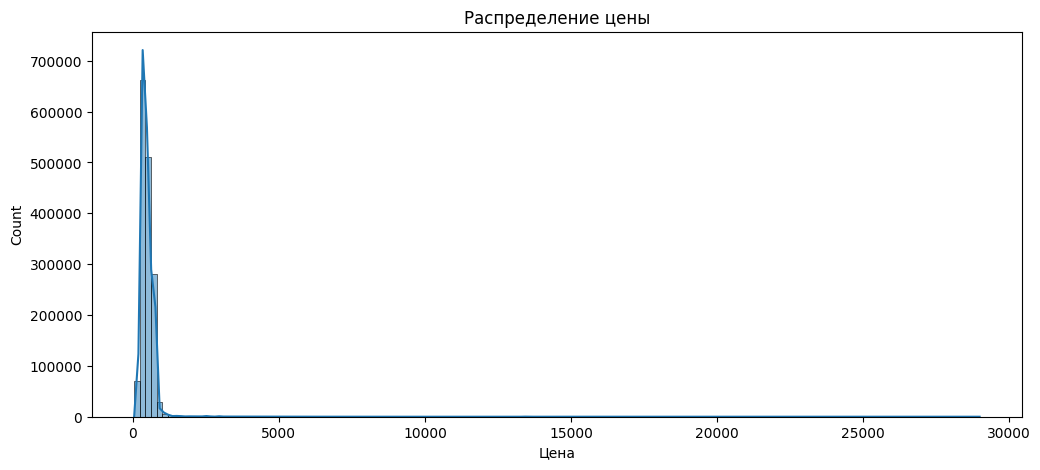

In [13]:
plt.figure(figsize=(12,5))
sns.histplot(df['Цена'], kde = True, bins = 150)
plt.title('Распределение цены')
plt.show()

Как видно по графику, наблюдается большой разрос по цене. Оснавная масса - значительно меньше 5000, но присутствует много выбросов.

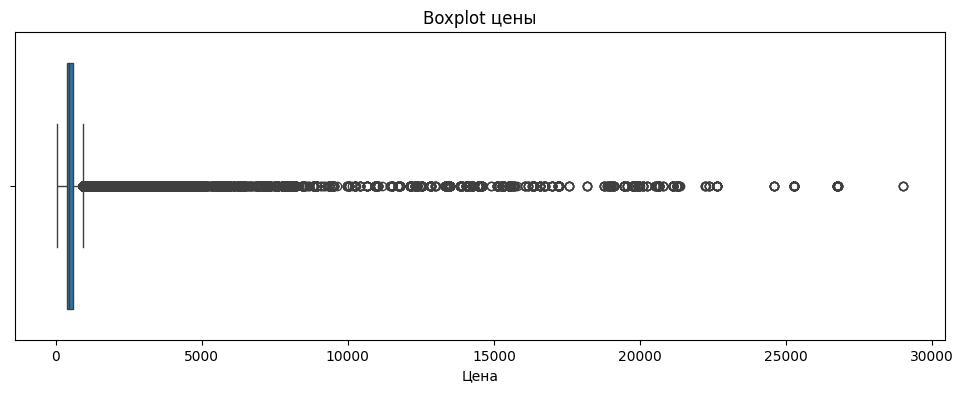

In [14]:
plt.figure(figsize=(12,4))
sns.boxplot(x=df['Цена'])
plt.title('Boxplot цены')
plt.show()

In [15]:
# Рассмотрим выбросы
df.sort_values('Цена',ascending = False).head(10)

,Дата парсинга,Выдача,Номенклатура,Рейтинг,Отзывы,Цена,Стоимость рекламы,Позиция с рекламой,Позиция до рекламы,Регион,Новинка,Модель,Запрос,Акция,Бренд,Название,Реклама,Тип рекламы,stock_total,level_rating
779480,2025-09-12,296,303841360,5.0,1,28996,685,296,118260,Краснодар,None,iPhone 13,чехол iphone 13,None,Nikolos Gadget,Смартфон iPhone 13 128gb зеленый восстановленный,Да,поиск,29,Высокий
1163781,2025-09-12,289,303841360,5.0,1,28996,685,289,118292,Москва,None,iPhone 13,чехол iphone 13,None,Nikolos Gadget,Смартфон iPhone 13 128gb зеленый восстановленный,Да,поиск,29,Высокий
376077,2025-09-12,288,303841360,5.0,1,28996,685,288,118603,Казань,None,iPhone 13,чехол iphone 13,None,Nikolos Gadget,Смартфон iPhone 13 128gb зеленый восстановленный,Да,поиск,29,Высокий
1513159,2025-09-12,254,315283618,5.0,1,26774,0,254,254,Новосибирск,None,iPhone XR в корпусе,чехол на iphone xr в корпусе 16 pro,None,Screenshot,"iPhone XR в корпусе 16 Pro 256 ГБ, титан Восст...",None,None,99,Высокий
1495197,2025-09-12,240,315283620,0.0,0,26774,0,240,240,Новосибирск,None,iPhone XR в корпусе,чехол на iphone xr в корпусе 16 pro,СКИДКИ ПОСПЕЛИ,Screenshot,"iPhone XR в корпусе 16 Pro 256 ГБ, золотой Вос...",None,None,100,Низкий
1527272,2025-09-12,265,452264278,0.0,0,26774,0,265,265,Новосибирск,None,iPhone XR в корпусе,чехол на iphone xr в корпусе 16 pro,None,Твой выбор!,"iPhone XR в корпусе 16 Pro 256 ГБ, золотой Вос...",None,None,100,Низкий
1386342,2025-09-12,156,315283619,5.0,1,26774,0,156,156,Новосибирск,None,iPhone XR в корпусе,чехол на iphone xr в корпусе 16 pro,СКИДКИ ПОСПЕЛИ,Screenshot,"iPhone XR в корпусе 16 Pro 256 ГБ, белый Восст...",None,None,99,Высокий
1540102,2025-09-12,275,452264275,0.0,0,26774,0,275,275,Новосибирск,None,iPhone XR в корпусе,чехол на iphone xr в корпусе 16 pro,None,Твой выбор!,"iPhone XR в корпусе 16 Pro 256 ГБ, черный Восс...",None,None,100,Низкий
318316,2025-09-12,242,315283620,0.0,0,26762,0,242,242,Казань,None,iPhone XR в корпусе,чехол на iphone xr в корпусе 16 pro,СКИДКИ ПОСПЕЛИ,Screenshot,"iPhone XR в корпусе 16 Pro 256 ГБ, золотой Вос...",None,None,100,Низкий
602531,2025-09-12,158,315283619,5.0,1,26762,0,158,158,Краснодар,None,iPhone XR в корпусе,чехол на iphone xr в корпусе 16 pro,СКИДКИ ПОСПЕЛИ,Screenshot,"iPhone XR в корпусе 16 Pro 256 ГБ, белый Восст...",None,None,99,Высокий


Можно заметить, что наибольшую цену имеют сами смартфоны, а не чехлы. 

In [16]:
mask = ~df['Название'].str.contains(r'^(смартфон|iPhone)', case=False, na=False)

# Применяем маску, чтобы посмотреть только строки без этих значений
df_filtered = df[mask]
df_filtered.sort_values('Цена',ascending = False).head()

,Дата парсинга,Выдача,Номенклатура,Рейтинг,Отзывы,Цена,Стоимость рекламы,Позиция с рекламой,Позиция до рекламы,Регион,Новинка,Модель,Запрос,Акция,Бренд,Название,Реклама,Тип рекламы,stock_total,level_rating
686929,2025-09-12,223,291490410,0.0,0,24599,0,223,223,Краснодар,None,iPhone 16,чехол на iphone 16 с гербом,None,Euphoria HM Premium,Чехол iPhone 16 Pro Max - Герб РФ Stingray Daw...,None,None,22,Низкий
776026,2025-09-12,293,214296150,5.0,1,24599,0,293,293,Краснодар,None,iPhone X/XS,чехол на iphone 10 с гербом,None,Euphoria HM Premium,Чехол iPhone 15 Pro Max - Герб РФ Stingray Daw...,None,None,22,Высокий
742055,2025-09-12,266,291488878,0.0,0,24599,0,266,266,Краснодар,None,iPhone 16,чехол на iphone 16 с гербом,None,Euphoria HM Premium,Чехол iPhone 16 Pro - Герб РФ Stingray Daw Min...,None,None,22,Низкий
715069,2025-09-12,245,291488878,0.0,0,24599,0,245,245,Краснодар,None,iPhone 16 Pro,чехол на iphone 16 pro с гербом,None,Euphoria HM Premium,Чехол iPhone 16 Pro - Герб РФ Stingray Daw Min...,None,None,22,Низкий
553815,2025-09-12,121,291490410,0.0,0,24599,0,121,121,Краснодар,None,iPhone 16 Pro Max,чехол на iphone 16 pro max с гербом,None,Euphoria HM Premium,Чехол iPhone 16 Pro Max - Герб РФ Stingray Daw...,None,None,22,Низкий


In [17]:
len(df_filtered)

1567665

Исключив смартфоны можно заметить, что остались чехлы также с большой стоимостью. Для последующего анализа стоит уточнить цели - нужно анализировать все запросы - с чехлами с большой стоимостью, или задать границу по квартилю или другому значению. Можно разделить набор данных по группам(по стоимости). Основная масса цен находится между 372 и 597. Все, что выше 597, можно рассматривать как дорогие товары (целесообразно будет также отдельно рассматривать товары дороже 3000-4000 тысяч).

In [18]:
df_filtered['Цена'].describe()

count    1.567665e+06
mean     4.946248e+02
std      3.475830e+02
min      4.400000e+01
25%      3.720000e+02
50%      4.340000e+02
75%      5.970000e+02
max      2.459900e+04
Name: Цена, dtype: float64

In [19]:
q75 = df['Цена'].quantile(0.75)

# фильтрация
filtered_df_price = df[df['Цена'] <= q75]

In [20]:
filtered_df_price['Цена'].describe()

count    1.221201e+06
mean     4.055867e+02
std      9.522450e+01
min      4.400000e+01
25%      3.630000e+02
50%      4.050000e+02
75%      4.590000e+02
max      5.970000e+02
Name: Цена, dtype: float64

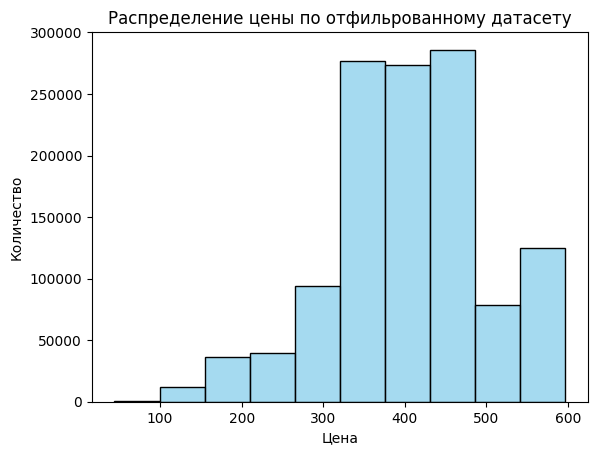

In [21]:
sns.histplot(filtered_df_price['Цена'], bins = 10, color = 'skyblue')
plt.title('Распределение цены по отфильрованному датасету')
plt.ylabel('Количество')
plt.show()

# Рейтинг

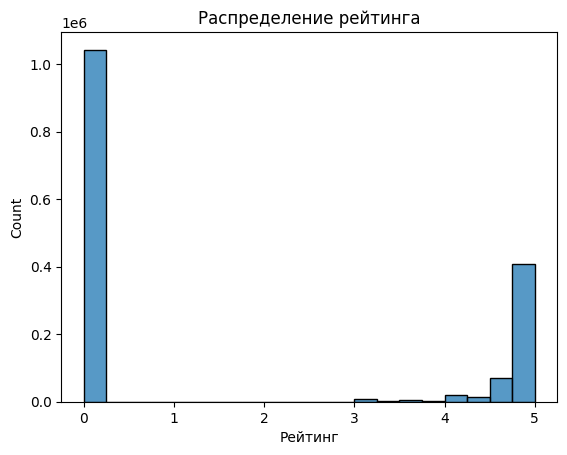

In [22]:
sns.histplot(df['Рейтинг'], bins=20)
plt.title('Распределение рейтинга')
plt.show()

 По диаграммам видно, что в колонке Рейтинг нет выбросов, все значения находятся в диапозоне от 0 до 5.

 Медианным значением является 0, болше всего товаров без рейтинга. В зависимости от целей и задач можно не учитывать эти значения,
 но в целом полезно знать и позициях товаров без рейтинга.

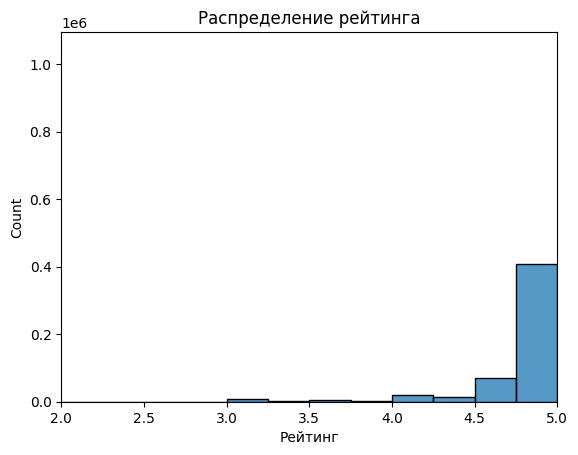

In [23]:
sns.histplot(df['Рейтинг'], bins=20)
plt.xlim(2,5)
plt.title('Распределение рейтинга')
plt.show()

5) Визуализируйте пропуски гистограммой. Чем объясняются эти пропуски? Как с ними поступить?

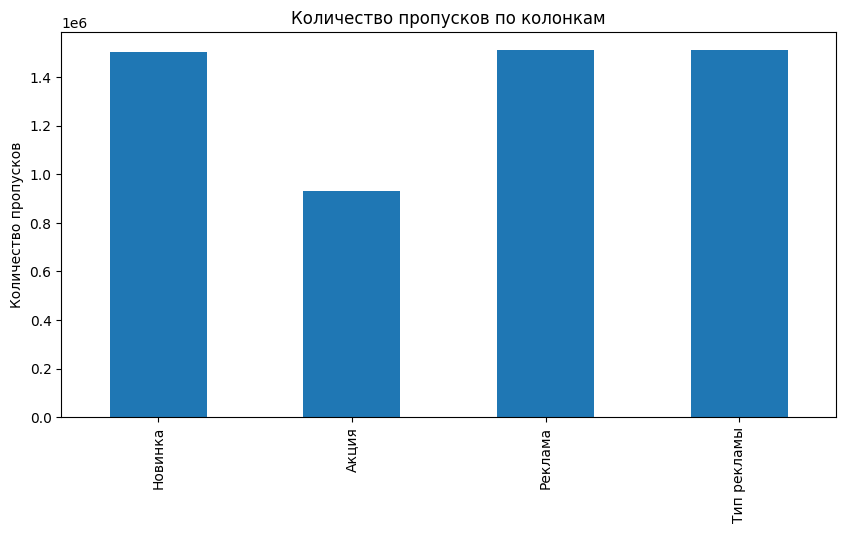

In [24]:
# Считаем пропуски
missing_counts = df.isna().sum()

# Фильтруем только колонки с пропусками
missing_counts = missing_counts[missing_counts > 0]

missing_counts.plot(kind='bar', figsize=(10,5))
plt.title('Количество пропусков по колонкам')
plt.ylabel('Количество пропусков')
plt.show()

Пропуски в данных связаны с особенностями маркетплейса: 
не все товары участвуют в акциях, не у всех есть остатки на складе и не на все включена реклама. 
В категориальных колонках пропуски можно заменить на отдельную категорию, 
в числовых — при необходимости заменить на 0 или исключить из расчетов.

# Визуализация

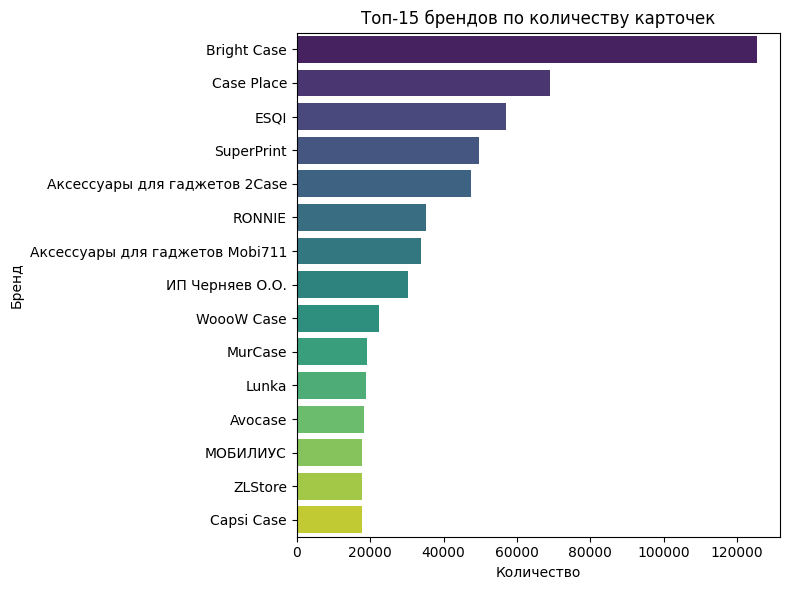

In [25]:
if 'Бренд' in df.columns:
    top_brands = df['Бренд'].value_counts().nlargest(15)
    plt.figure(figsize=(8,6))
    sns.barplot(x=top_brands.values, y=top_brands.index, palette='viridis')
    plt.title('Топ-15 брендов по количеству карточек')
    plt.xlabel('Количество')
    plt.ylabel('Бренд')
    plt.tight_layout()
    plt.show()

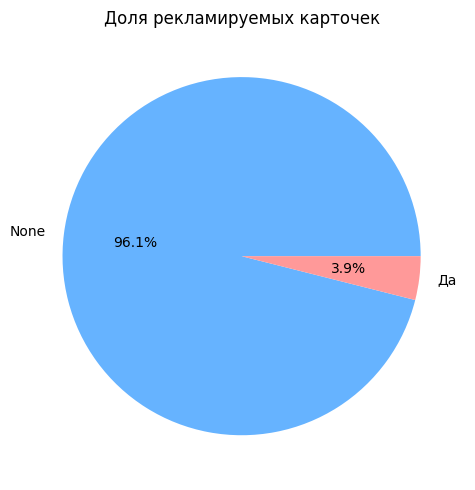

In [26]:
if 'Реклама' in df.columns:
    plt.figure(figsize=(5,5))
    df['Реклама'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
    plt.title('Доля рекламируемых карточек')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

График зависимости цены от рейтинга по отфильтрованным ценам

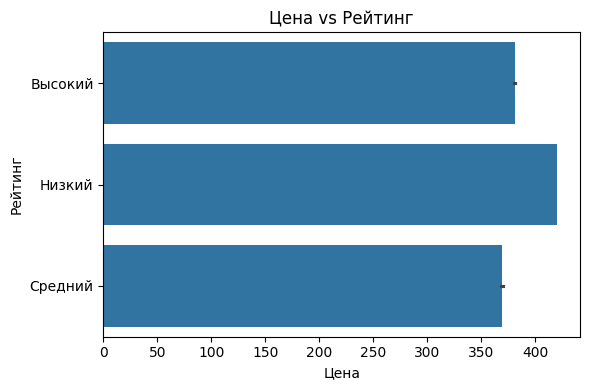

In [27]:
if 'Цена' in filtered_df_price.columns and 'level_rating' in filtered_df_price.columns:
    plt.figure(figsize=(6,4))
    sns.barplot(data=filtered_df_price, x='Цена', y='level_rating')
    plt.title('Цена vs Рейтинг')
    plt.xlabel('Цена')
    plt.ylabel('Рейтинг')
    plt.tight_layout()
    plt.show()

# 3. Анализ данных

1) Рассчитайте медианную позицию в выдаче по уровням рейтинга

In [28]:
median_position = df.groupby('level_rating')['Выдача'].median()
print(median_position)

level_rating
Высокий    124.0
Низкий     158.0
Средний    143.0
Name: Выдача, dtype: float64


2) Сравните среднюю позицию товаров с одинаковой Номенклатурой в разных регионах. Приведите топ-20 номенклатур с наибольшим расхождением (например, в одном регионе — в топ-3, а в другом — ниже 30-го места).

In [29]:
avg_position = df.groupby(['Номенклатура', 'Регион'])['Выдача'].mean().reset_index()
avg_position.head(8)

,Номенклатура,Регион,Выдача
0,3001211,Казань,75.00
1,3001211,Краснодар,101.00
2,3001211,Москва,64.00
3,3001211,Новосибирск,137.00
4,3001217,Казань,84.50
5,3001217,Краснодар,127.75
6,3001217,Москва,61.00
7,3001217,Новосибирск,59.50


In [30]:
# минимальные позиции по номенклатуре и региону
positions = df.groupby(['Номенклатура', 'Регион'])['Выдача'].min().reset_index()

# Считаем минимальные и максимальные позиции и соответствующие регионы
summary = positions.groupby('Номенклатура', group_keys=False).apply(
    lambda x: pd.Series({
        'Макс_позиция': x['Выдача'].max(),
        'Макс_регион': x.loc[x['Выдача'].idxmax(), 'Регион'],
        'Мин_позиция': x['Выдача'].min(),
        'Мин_регион': x.loc[x['Выдача'].idxmin(), 'Регион'],
        'Разница': x['Выдача'].max() - x['Выдача'].min()
    })
)

# Топ-20 номенклатур с наибольшим расхождением
top20 = summary.sort_values('Разница', ascending=False).head(20)
print(top20)

              Макс_позиция  Макс_регион  Мин_позиция   Мин_регион  Разница
Номенклатура                                                              
436667993              297  Новосибирск            2       Казань      295
277048887              299       Москва            5       Казань      294
182273140              296       Казань            3       Москва      293
386852288              299       Москва            8    Краснодар      291
284575843              297       Москва            6    Краснодар      291
405410014              299       Москва           10       Казань      289
277964510              296  Новосибирск            7    Краснодар      289
212513464              294  Новосибирск            5       Казань      289
454100670              292       Москва            3    Краснодар      289
476293705              293  Новосибирск            4    Краснодар      289
194443253              299       Москва           10       Казань      289
391008726              29

3) Корреляционный анализ: какие факторы больше всего коррелируют с “Выдача”?

In [34]:
df.corr(numeric_only=True)

,Выдача,Номенклатура,Рейтинг,Отзывы,Цена,Стоимость рекламы,Позиция с рекламой,Позиция до рекламы,stock_total
Выдача,1.000000,0.078381,-0.124228,-0.055935,0.024942,-0.082663,0.999998,0.118262,0.001345
Номенклатура,0.078381,1.000000,-0.380300,-0.120371,0.043242,0.023390,0.078384,0.062586,0.150424
Рейтинг,-0.124228,-0.380300,1.000000,0.116906,-0.049420,0.150028,-0.124233,0.044999,-0.072893
Отзывы,-0.055935,-0.120371,0.116906,1.000000,-0.033574,0.118645,-0.055938,0.003729,0.049433
Цена,0.024942,0.043242,-0.049420,-0.033574,1.000000,0.032492,0.024943,0.054012,-0.019309
Стоимость рекламы,-0.082663,0.023390,0.150028,0.118645,0.032492,1.000000,-0.082695,0.292254,0.016970
Позиция с рекламой,0.999998,0.078384,-0.124233,-0.055938,0.024943,-0.082695,1.000000,0.118263,0.001344
Позиция до рекламы,0.118262,0.062586,0.044999,0.003729,0.054012,0.292254,0.118263,1.000000,-0.009677
stock_total,0.001345,0.150424,-0.072893,0.049433,-0.019309,0.016970,0.001344,-0.009677,1.000000


<Axes: >

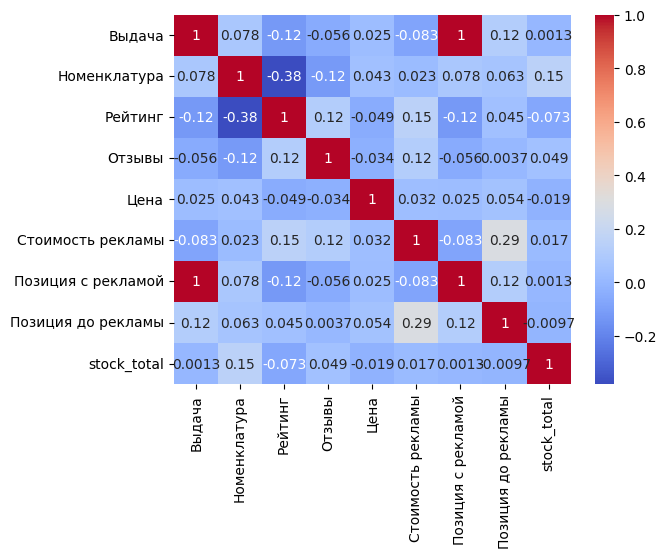

In [35]:
sns.heatmap(df.corr(numeric_only=True), annot = True, cmap = 'coolwarm')

Главный фактор, коррелирующий с позицией в выдаче - это Позиция с рекламой. Рейтинг имеет небольшое влияние: товары с высоким рейтингом чаще показываются выше. 
Остальные числовые признаки практически не влияют линейно на позицию.

# 4. Бизнес-выводы

4.1 На позицию товара в поисковой выдаче наиболее сильно влияет реклама (позиция с рекламой), второстепенно - рейтинг товара. Остальные показатели, такие как цена, количество отзывов или остатки на складе, практически не влияют линейно. Это отражено в таблице корреляции и тепловой карте выше.

4.2
Анализ данных показывает, что главный фактор, влияющий на позицию товара в выдаче, — это использование рекламы. Как видно из корреляционного анализа, позиция с рекламой практически полностью определяется выдачей, поэтому включение рекламы и грамотное управление ее бюджетом и позициями позволяет существенно поднять товар в выдаче. 
Кроме того, повышение рейтинга товаров также может оказывать влияние. Хотя корреляция рейтинга с выдачей отрицательная, она слабая, все же товары с более высоким рейтингом немного чаще оказываются выше. Это означает, что стоит работать над качеством товара, стимулировать честные отзывы и повышать удовлетворенность покупателей. 
Позиции товаров сильно различаются по регионам из-за различий в спросе и уровне конкуренции, поэтому планирование рекламных кампаний и логистики с учетом региональной специфики особенно важно для топовых номенклатур. Наличие достаточного объема товара на складах, несмотря на низкую корреляцию stock_total с позицией, также играет роль для корректного ранжирования и доступности. 
Что касается цены, прямая линейная корреляция с позицией почти нулевая, но ценовые акции и скидки могут опосредованно улучшать кликабельность и продажи, что в конечном счете влияет на алгоритм выдачи, поэтому целесообразно проводить таргетированные акции для повышения видимости товаров.
Основной способ поднять позицию товара — это грамотная настройка рекламы и управление ее бюджетом. Второстепенно — повышение рейтинга и учет региональных особенностей, обеспечение достаточного количества товара на складах.

Возможные гипотезы для A/B тестов

Гипотеза 1 - влияние рекламной позиции на выдачу и продажи

Формулировка: Товары с рекламой на более высоких позициях в выдаче получают больше кликов и продаж, чем те же товары без рекламы или с более низкой рекламной позицией.

Проверка:

Разделить товары одной номенклатуры на две группы: с рекламой в топ-позициях и без рекламы/с рекламой ниже.

Сравнить средние показатели Выдача или продажи между группами.

Гипотеза 2 - влияние рейтинга на позицию в выдаче

Формулировка: Товары с более высоким рейтингом получают лучшие позиции в выдаче по сравнению с товарами той же номенклатуры с низким рейтингом.

Проверка:

Разделить товары на группы по рейтингу (низкий, средний, высокий).

Сравнить средние позиции Выдача внутри одной номенклатуры или категории товаров.